La prima parte del codice è quasi identica a quella nella prima parte dell'assignment. Se si vogliono unire le due parti nello stesso codice, ci sono alcune piccole modifiche da fare:
- aggiunta di alcuni import (cancellare il comando pip)
- piccola modifica nell'ultima parte della definizione della training function. In particolare:
    1. Viene settato un seed per il training, quindi eventuali rerun della prima parte potrebbero modificare le performance
    2. Viene utilizzata la validation accuracy invece che la validation loss per l'early stopping

Oltre a ciò, è necessario aggiungere tutta la parte successiva al markdown contenente la spiegazione della seconda parte dell'assignment.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [31]:
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
from typing import List, Tuple
import copy
import cv2
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [32]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.4.0
12.3
True


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [35]:
mean = [0.5306, 0.3964, 0.2564]
std = [0.2293, 0.2060, 0.1746]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

# Part 2: fine-tune an existing network

### Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

### 1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

Definition of useful functions

In [54]:
# Training function
def train_model(seed, model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train() 
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        if epoch_val_acc >= best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(best_acc)
        else:
            scheduler.step()

    print(f'Maximum val accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [37]:
def restore_initial_setup(seed, train_dataset, test_dataset, val_dataset, device):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    model = models.resnet18(weights='IMAGENET1K_V1')

    # The final layer is modified to have 43 classes as output
    num_classes = 43
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model = model.to(device)

    # loss function
    loss_fn = nn.CrossEntropyLoss()

    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

    # learning rate scheduler
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    batch_size = 32
    num_epochs = 30
    patience = 7

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader

def experiment_runner(n, description, seed, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader):
    # set seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'EXPERIMENT {n}: {description} - using seed = {seed}')
    print('\n')
    # train the model
    model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(seed, model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

    print('\n TRAINING AND VALIDATION LOSS VARIATION OVER THE EPOCHS')
    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('\n VALIDATION ACCURACY VARIATION OVER THE EPOCHS')
    # Plot the validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return


### **Initial model**

The best setup exploited in the first part of the Assignment is used. Different seeds are set for better understanding of the initial performance.

**SEED = 42**

In [38]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(42, train_dataset, test_dataset, val_dataset, device)

EXPERIMENT 0: INITIAL SETUP - using seed = 42


Epoch [1/30], Train Loss: 1.4170 Acc: 0.6742 | Val Loss: 1.1248 Acc: 0.7196
Epoch [2/30], Train Loss: 0.2238 Acc: 0.9754 | Val Loss: 0.7893 Acc: 0.7804
Epoch [3/30], Train Loss: 0.0616 Acc: 0.9989 | Val Loss: 0.6838 Acc: 0.8074
Epoch [4/30], Train Loss: 0.0283 Acc: 1.0000 | Val Loss: 0.6860 Acc: 0.8277
Epoch [5/30], Train Loss: 0.0176 Acc: 1.0000 | Val Loss: 0.6447 Acc: 0.8209
Epoch [6/30], Train Loss: 0.0131 Acc: 1.0000 | Val Loss: 0.6120 Acc: 0.8142
Epoch [7/30], Train Loss: 0.0253 Acc: 0.9962 | Val Loss: 0.7629 Acc: 0.7872
Epoch [8/30], Train Loss: 0.0170 Acc: 0.9981 | Val Loss: 0.7043 Acc: 0.7973
Epoch [9/30], Train Loss: 0.0107 Acc: 0.9996 | Val Loss: 0.6873 Acc: 0.8108
Epoch [10/30], Train Loss: 0.0094 Acc: 1.0000 | Val Loss: 0.6736 Acc: 0.8074
Epoch [11/30], Train Loss: 0.0086 Acc: 1.0000 | Val Loss: 0.6430 Acc: 0.8108
Early stopping triggered
Maximum val accuracy: 0.8277

 TRAINING AND VALIDATION LOSS VARIATION OVER THE EPOCHS


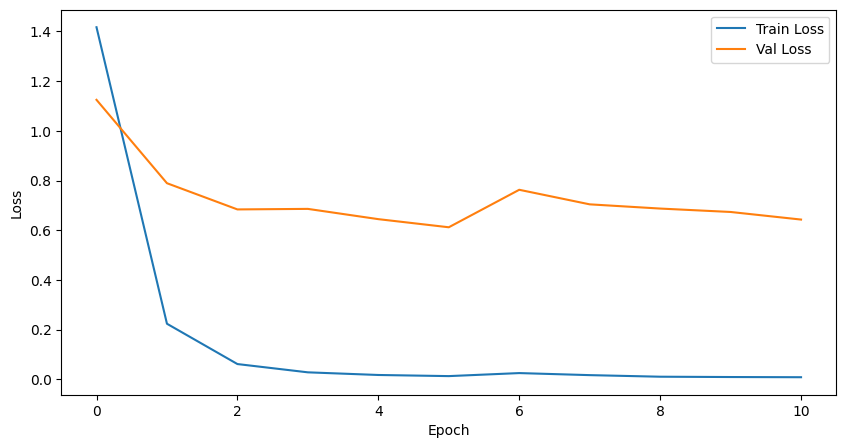


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


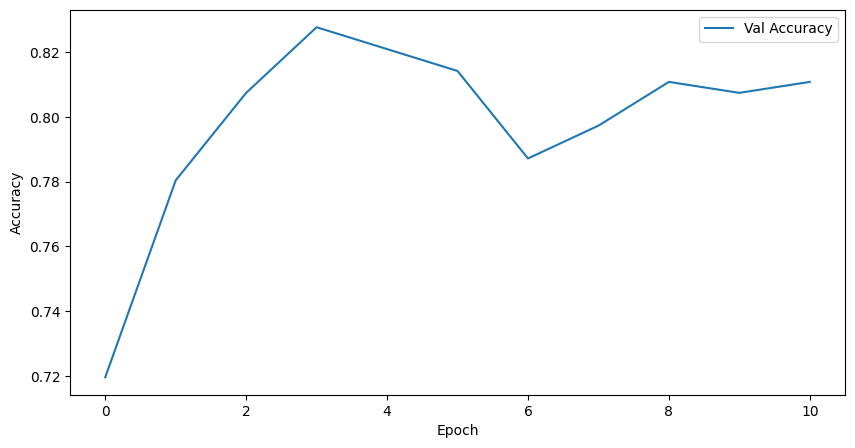

In [39]:
experiment_runner(0, 'INITIAL SETUP', 42, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**SEED = 1**

In [40]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(42, train_dataset, test_dataset, val_dataset, device)

EXPERIMENT 0: INITIAL SETUP - using seed = 1


Epoch [1/30], Train Loss: 1.4454 Acc: 0.6742 | Val Loss: 1.0931 Acc: 0.6892
Epoch [2/30], Train Loss: 0.2324 Acc: 0.9746 | Val Loss: 0.7094 Acc: 0.8243
Epoch [3/30], Train Loss: 0.0643 Acc: 0.9977 | Val Loss: 0.6179 Acc: 0.8277
Epoch [4/30], Train Loss: 0.0309 Acc: 0.9996 | Val Loss: 0.5777 Acc: 0.8277
Epoch [5/30], Train Loss: 0.0185 Acc: 0.9996 | Val Loss: 0.5831 Acc: 0.8209
Epoch [6/30], Train Loss: 0.0144 Acc: 1.0000 | Val Loss: 0.5146 Acc: 0.8615
Epoch [7/30], Train Loss: 0.0162 Acc: 0.9985 | Val Loss: 0.5552 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0112 Acc: 0.9992 | Val Loss: 0.5545 Acc: 0.8311
Epoch [9/30], Train Loss: 0.0086 Acc: 1.0000 | Val Loss: 0.5172 Acc: 0.8446
Epoch [10/30], Train Loss: 0.0089 Acc: 1.0000 | Val Loss: 0.5371 Acc: 0.8446
Epoch [11/30], Train Loss: 0.0082 Acc: 0.9996 | Val Loss: 0.5422 Acc: 0.8446
Epoch [12/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5253 Acc: 0.8514
Epoch [13/30], Train Loss: 0.0078 Acc:

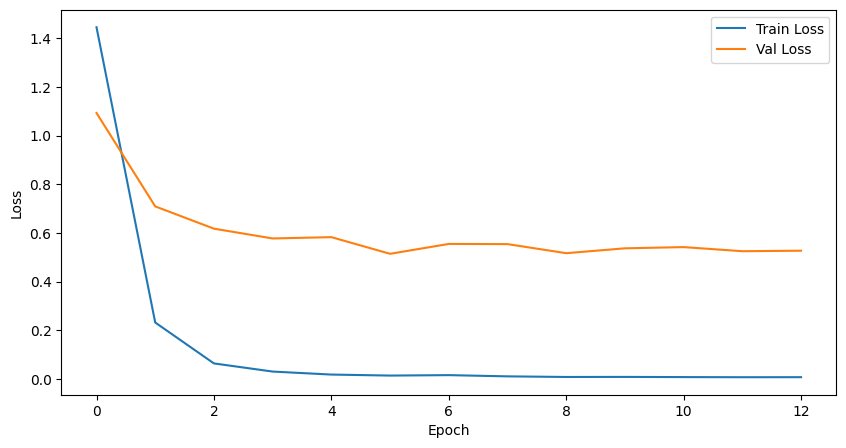


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


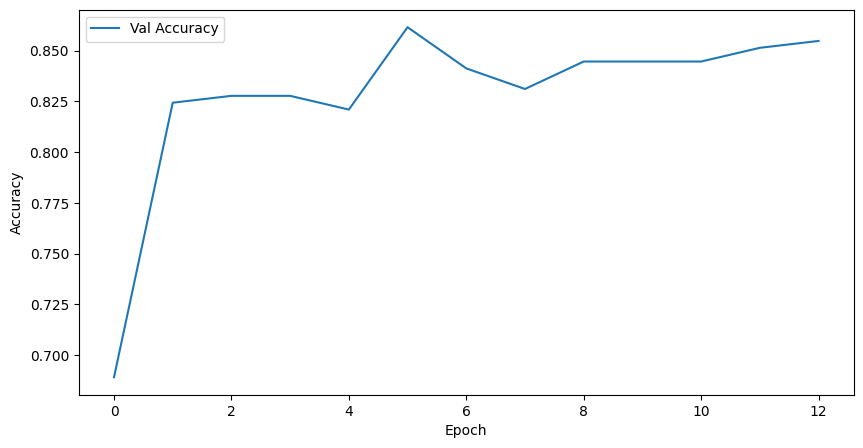

In [41]:
experiment_runner(0, 'INITIAL SETUP', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**SEED = 129**

In [42]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(129, train_dataset, test_dataset, val_dataset, device)

EXPERIMENT 0: INITIAL SETUP - using seed = 129


Epoch [1/30], Train Loss: 1.5102 Acc: 0.6568 | Val Loss: 1.0199 Acc: 0.7331
Epoch [2/30], Train Loss: 0.2345 Acc: 0.9780 | Val Loss: 0.6948 Acc: 0.8142
Epoch [3/30], Train Loss: 0.0684 Acc: 0.9981 | Val Loss: 0.5983 Acc: 0.8378
Epoch [4/30], Train Loss: 0.0308 Acc: 0.9992 | Val Loss: 0.5456 Acc: 0.8446
Epoch [5/30], Train Loss: 0.0181 Acc: 1.0000 | Val Loss: 0.5557 Acc: 0.8378
Epoch [6/30], Train Loss: 0.0118 Acc: 1.0000 | Val Loss: 0.5215 Acc: 0.8412
Epoch [7/30], Train Loss: 0.0089 Acc: 1.0000 | Val Loss: 0.4797 Acc: 0.8581
Epoch [8/30], Train Loss: 0.0078 Acc: 1.0000 | Val Loss: 0.5124 Acc: 0.8514
Epoch [9/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.4819 Acc: 0.8581
Epoch [10/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.4888 Acc: 0.8514
Epoch [11/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.4815 Acc: 0.8615
Epoch [12/30], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.4772 Acc: 0.8750
Epoch [13/30], Train Loss: 0.0063 Ac

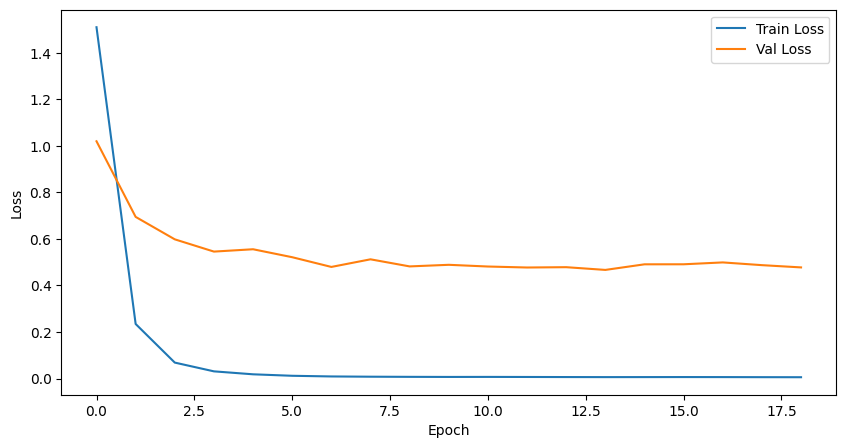


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


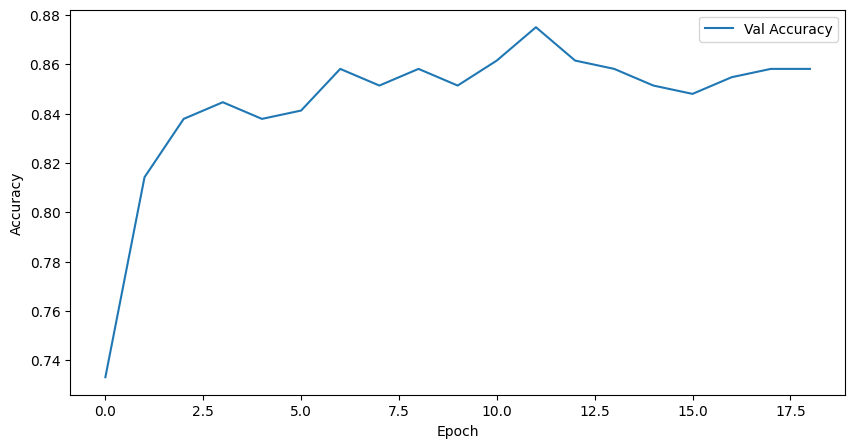

In [43]:
experiment_runner(0, 'INITIAL SETUP', 129, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

Following these observations, subsequent experiments will utilize seed = 1, showing an average initial performance.

### 2. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### EXPERIMENT 1 - EXPLOITATION OF CYCLICAL LEARNING RATES

> Training with cyclical learning rates instead of fixed values achieves improved classification accuracy without a need to tune and often in fewer iterations.>

Source: [Smith - Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186)

The proposed scheduler, specifically, changes the learning rate according to the 1cycle policy, described in [Smith, Topin - Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](http://arxiv.org/abs/1708.07120)

In [44]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=num_epochs)

EXPERIMENT 1: EXPLOITATION OF CYCLICAL LEARNING RATES - using seed = 1


Epoch [1/30], Train Loss: 2.2793 Acc: 0.4485 | Val Loss: 1.8832 Acc: 0.5135
Epoch [2/30], Train Loss: 0.8512 Acc: 0.8527 | Val Loss: 1.2997 Acc: 0.6554
Epoch [3/30], Train Loss: 0.3757 Acc: 0.9678 | Val Loss: 1.0331 Acc: 0.7297
Epoch [4/30], Train Loss: 0.1867 Acc: 0.9936 | Val Loss: 0.8870 Acc: 0.7601
Epoch [5/30], Train Loss: 0.1010 Acc: 0.9989 | Val Loss: 0.7947 Acc: 0.7905
Epoch [6/30], Train Loss: 0.0650 Acc: 0.9989 | Val Loss: 0.7127 Acc: 0.7973
Epoch [7/30], Train Loss: 0.0438 Acc: 0.9992 | Val Loss: 0.6838 Acc: 0.8074
Epoch [8/30], Train Loss: 0.0332 Acc: 0.9989 | Val Loss: 0.6855 Acc: 0.8007
Epoch [9/30], Train Loss: 0.0251 Acc: 0.9996 | Val Loss: 0.6560 Acc: 0.8142
Epoch [10/30], Train Loss: 0.0218 Acc: 1.0000 | Val Loss: 0.6769 Acc: 0.7905
Epoch [11/30], Train Loss: 0.0168 Acc: 1.0000 | Val Loss: 0.6307 Acc: 0.8074
Epoch [12/30], Train Loss: 0.0141 Acc: 1.0000 | Val Loss: 0.6287 Acc: 0.8041
Epoch [13/30

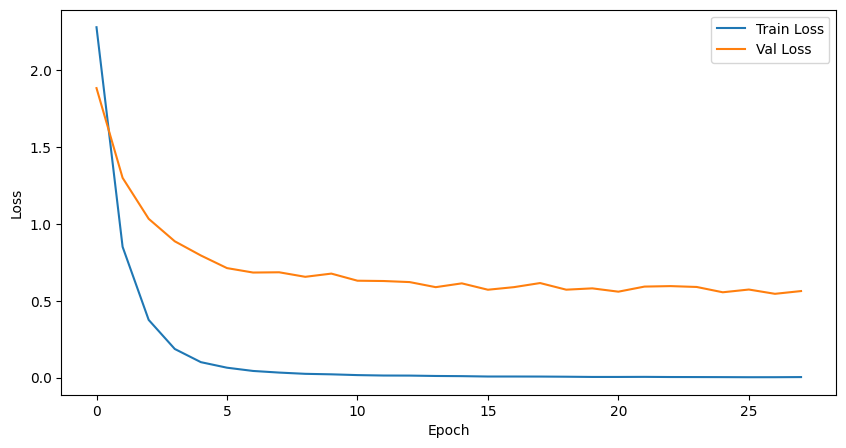


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


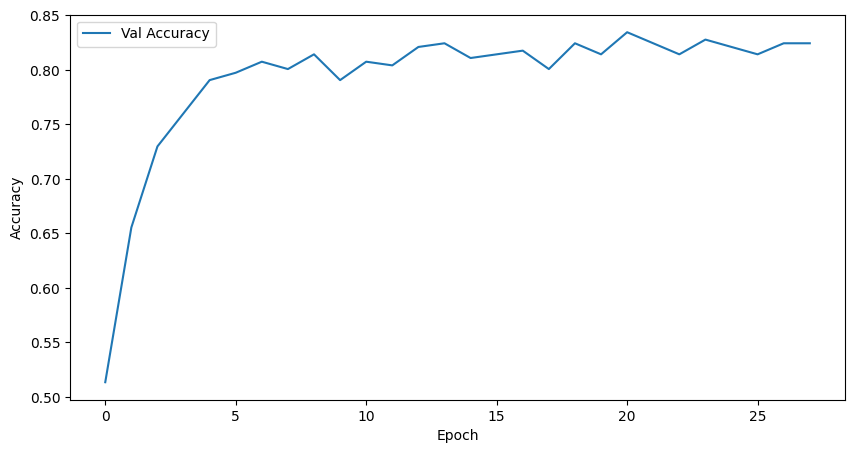

In [45]:
experiment_runner(1, 'EXPLOITATION OF CYCLICAL LEARNING RATES', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, the exploitation of this particular scheduler did not succeed in improving validation accuracy. However, a following experiment will focus on the comparison of different schedulers, in the attempt of finding one achieving a better validation performance. 

### EXPERIMENT 2 - EXPLOITATION OF DIFFERENT SCHEDULERS

In this experiment, different schedulers are compared:
* [MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html)
* [ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR)
* [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR)
* [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau)

**MultiStepLR Scheduler**

In [46]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

EXPERIMENT 2: MULTISTEPLR SCHEDULER - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0196 Acc: 0.9973 | Val Loss: 0.6282 Acc: 0.8243
Epoch [9/30], Train Loss: 0.0084 Acc: 1.0000 | Val Loss: 0.5706 Acc: 0.8311
Epoch [10/30], Train Loss: 0.0064 Acc: 1.0000 | Val Loss: 0.5748 Acc: 0.8277
Epoch [11/30], Train Loss: 0.0047 Acc: 1.0000 | Val Loss: 0.5425 Acc: 0.8480
Epoch [12/30], Train Loss: 0.0036 Acc: 1.0000 | Val Loss: 0.5457 Acc: 0.8378
Epoch [13/30], Train Loss: 0.0

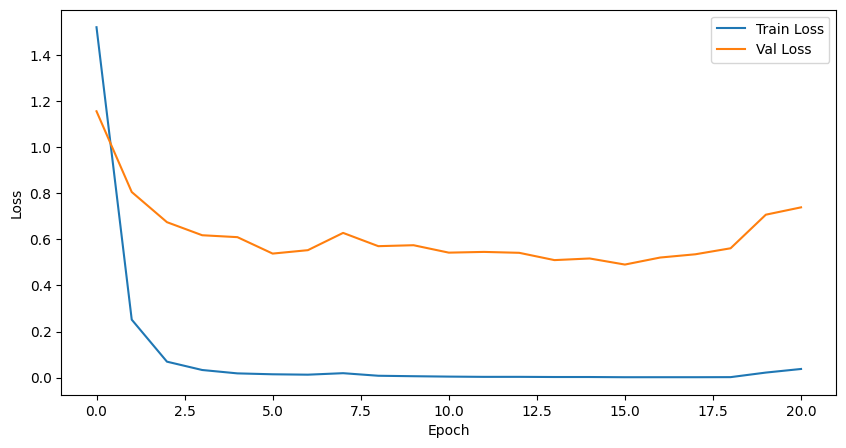


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


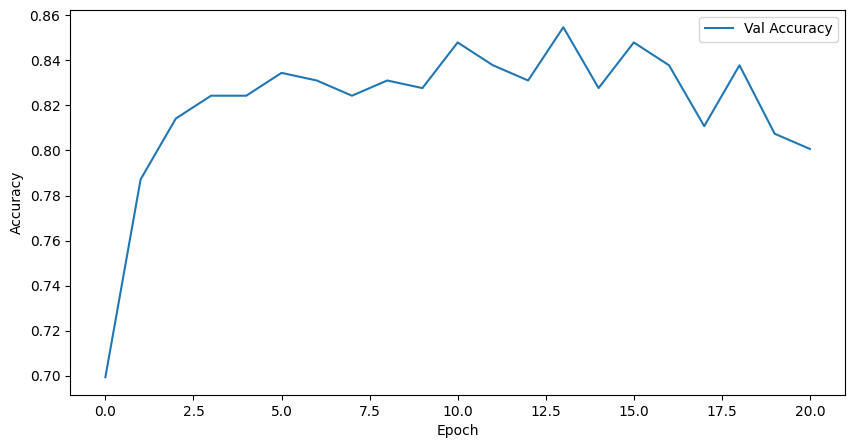

In [47]:
experiment_runner(2, 'MULTISTEPLR SCHEDULER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**ExponentialLR scheduler**

In [48]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

scheduler = ExponentialLR(optimizer, gamma=0.95)

EXPERIMENT 2: EXPONENTIALLR SCHEDULER - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2554 Acc: 0.9727 | Val Loss: 0.8070 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0733 Acc: 0.9981 | Val Loss: 0.6821 Acc: 0.8041
Epoch [4/30], Train Loss: 0.0351 Acc: 0.9996 | Val Loss: 0.6220 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0208 Acc: 1.0000 | Val Loss: 0.6259 Acc: 0.8108
Epoch [6/30], Train Loss: 0.0164 Acc: 1.0000 | Val Loss: 0.5459 Acc: 0.8243
Epoch [7/30], Train Loss: 0.0137 Acc: 0.9996 | Val Loss: 0.5534 Acc: 0.8243
Epoch [8/30], Train Loss: 0.0140 Acc: 0.9989 | Val Loss: 0.6321 Acc: 0.8041
Epoch [9/30], Train Loss: 0.0092 Acc: 1.0000 | Val Loss: 0.5728 Acc: 0.8176
Epoch [10/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.6096 Acc: 0.8074
Epoch [11/30], Train Loss: 0.0065 Acc: 1.0000 | Val Loss: 0.5720 Acc: 0.8277
Epoch [12/30], Train Loss: 0.0051 Acc: 1.0000 | Val Loss: 0.5642 Acc: 0.8209
Epoch [13/30], Train Loss: 0

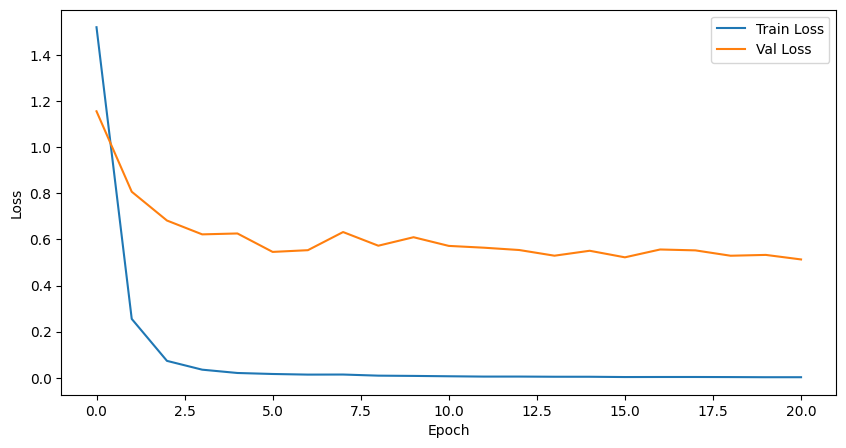


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


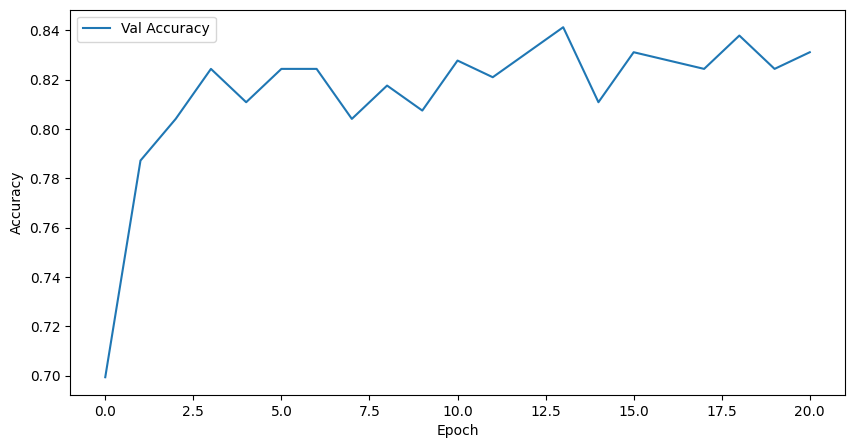

In [49]:
experiment_runner(2, 'EXPONENTIALLR SCHEDULER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**CosineAnnealingLR scheduler**

In [50]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

scheduler = CosineAnnealingLR(optimizer, T_max=50)

EXPERIMENT 2: COSINEANNEALINGLR SCHEDULER - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8061 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0696 Acc: 0.9985 | Val Loss: 0.6734 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0335 Acc: 0.9985 | Val Loss: 0.6210 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0188 Acc: 1.0000 | Val Loss: 0.6111 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0149 Acc: 1.0000 | Val Loss: 0.5381 Acc: 0.8277
Epoch [7/30], Train Loss: 0.0129 Acc: 0.9996 | Val Loss: 0.5514 Acc: 0.8345
Epoch [8/30], Train Loss: 0.0178 Acc: 0.9977 | Val Loss: 0.6315 Acc: 0.8209
Epoch [9/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5718 Acc: 0.8277
Epoch [10/30], Train Loss: 0.0064 Acc: 1.0000 | Val Loss: 0.5918 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0049 Acc: 1.0000 | Val Loss: 0.5465 Acc: 0.8446
Epoch [12/30], Train Loss: 0.0038 Acc: 1.0000 | Val Loss: 0.5483 Acc: 0.8345
Epoch [13/30], Train Los

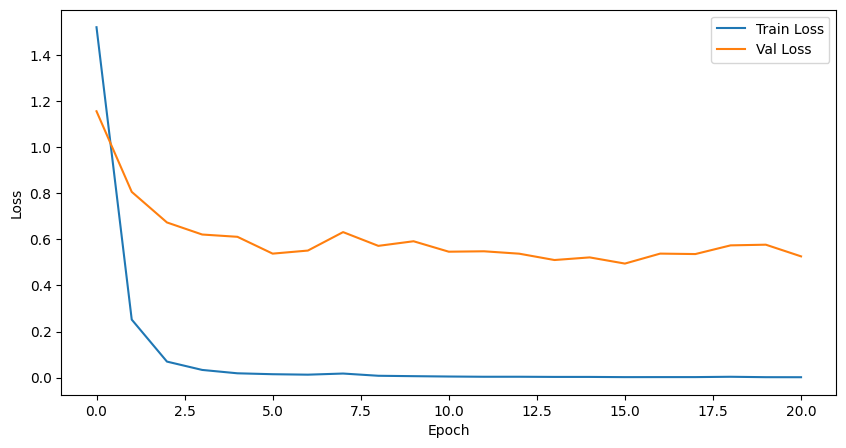


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


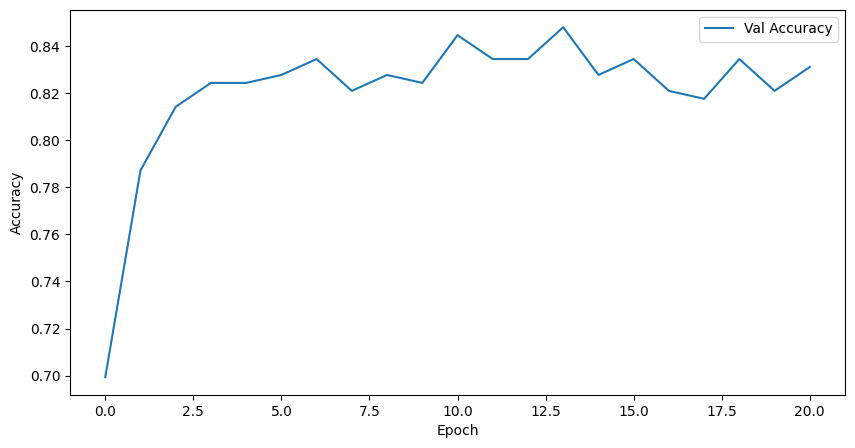

In [51]:
experiment_runner(2, 'COSINEANNEALINGLR SCHEDULER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**ReduceLROnPlateau scheduler**

In [55]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

EXPERIMENT 2: REDUCELRONPLAUTEAU SCHEDULER - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0196 Acc: 0.9973 | Val Loss: 0.6282 Acc: 0.8243
Epoch [9/30], Train Loss: 0.0084 Acc: 1.0000 | Val Loss: 0.5706 Acc: 0.8311
Epoch [10/30], Train Loss: 0.0064 Acc: 1.0000 | Val Loss: 0.5748 Acc: 0.8277
Epoch [11/30], Train Loss: 0.0049 Acc: 1.0000 | Val Loss: 0.5545 Acc: 0.8412
Epoch [12/30], Train Loss: 0.0047 Acc: 1.0000 | Val Loss: 0.5548 Acc: 0.8378
Epoch [13/30], Train Lo

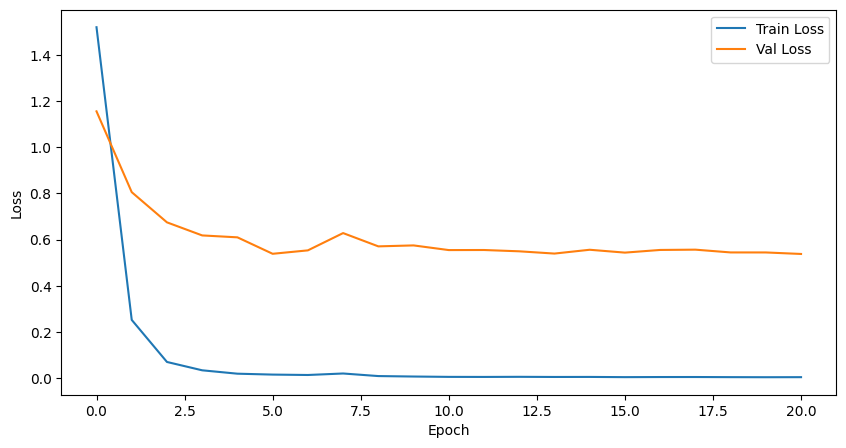


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


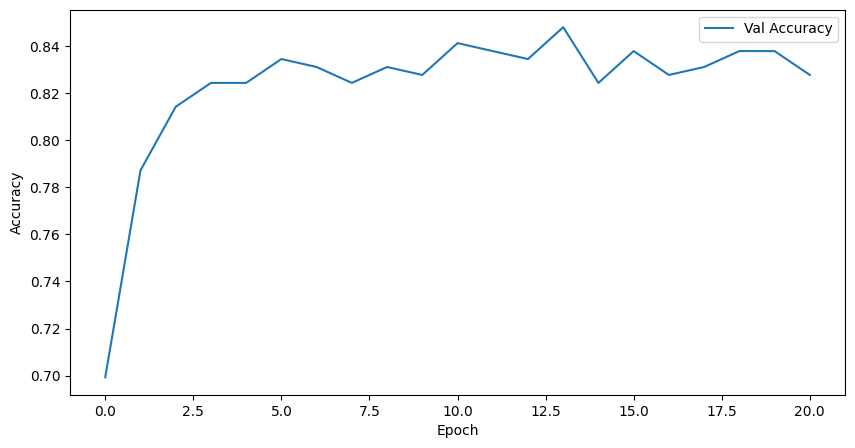

In [56]:
experiment_runner(2, 'REDUCELRONPLAUTEAU SCHEDULER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, no one of the proposed schedulers succeedes in improving performances.

### EXPERIMENT 3 - EXPLOITATION OF DIFFERENT OPTIMIZERS

In this experiment, different optimizers are exploited in the attempt of achieving better performances in terms of accuracy on the validation split:
* [SDG optimizer with momentum](http://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [Adagrad](http://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html)
* [NAG](http://mitliagkas.github.io/ift6085-2019/ift-6085-lecture-6-notes.pdf)
* [RAdam](https://pytorch.org/docs/stable/generated/torch.optim.RAdam)

**SDG optimizer with momentum**

In [57]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

EXPERIMENT 3: SDG OPTIMIZER WITH MOMENTUM - using seed = 1


Epoch [1/30], Train Loss: 2.4969 Acc: 0.3856 | Val Loss: 2.0560 Acc: 0.4899


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [2/30], Train Loss: 1.0986 Acc: 0.7617 | Val Loss: 1.4121 Acc: 0.6385
Epoch [3/30], Train Loss: 0.5650 Acc: 0.9163 | Val Loss: 1.1191 Acc: 0.6824
Epoch [4/30], Train Loss: 0.3272 Acc: 0.9644 | Val Loss: 0.9407 Acc: 0.7297
Epoch [5/30], Train Loss: 0.2073 Acc: 0.9867 | Val Loss: 0.8428 Acc: 0.7500
Epoch [6/30], Train Loss: 0.1442 Acc: 0.9913 | Val Loss: 0.7470 Acc: 0.7838
Epoch [7/30], Train Loss: 0.1033 Acc: 0.9962 | Val Loss: 0.6838 Acc: 0.8142
Epoch [8/30], Train Loss: 0.0785 Acc: 0.9966 | Val Loss: 0.6778 Acc: 0.8007
Epoch [9/30], Train Loss: 0.0619 Acc: 0.9992 | Val Loss: 0.6662 Acc: 0.8041
Epoch [10/30], Train Loss: 0.0535 Acc: 0.9996 | Val Loss: 0.6646 Acc: 0.7804
Epoch [11/30], Train Loss: 0.0424 Acc: 0.9989 | Val Loss: 0.6155 Acc: 0.8142
Epoch [12/30], Train Loss: 0.0368 Acc: 1.0000 | Val Loss: 0.6149 Acc: 0.8142
Epoch [13/30], Train Loss: 0.0354 Acc: 0.9989 | Val Loss: 0.6044 Acc: 0.8243
Epoch [14/30], Train Loss: 0.0287 Acc: 0.9996 | Val Loss: 0.6062 Acc: 0.8209
Epoch [

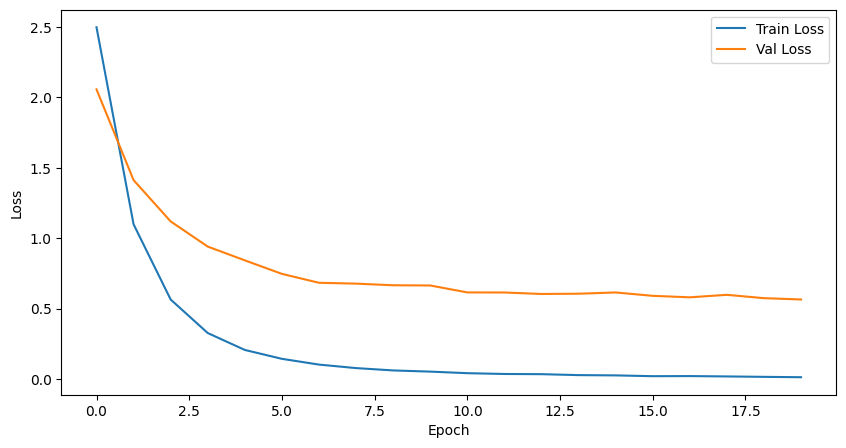


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


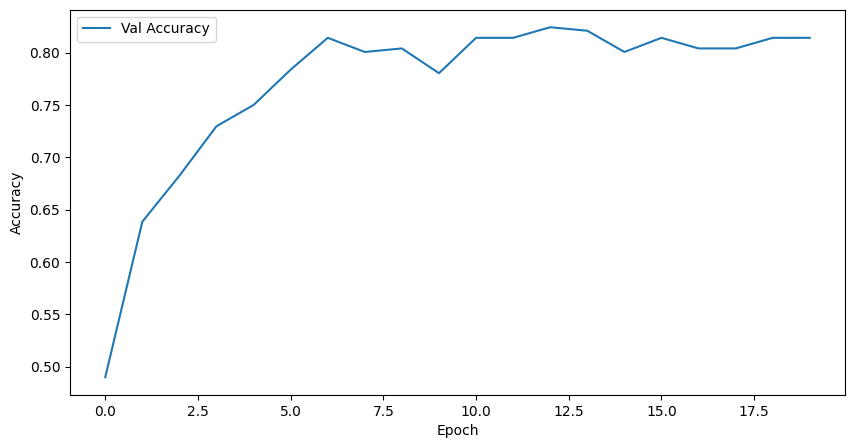

In [58]:
experiment_runner(3, 'SDG OPTIMIZER WITH MOMENTUM', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Adagrad optimizer**

In [59]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0001)

EXPERIMENT 3: ADAGRAD OPTIMIZER - using seed = 1


Epoch [1/30], Train Loss: 0.8727 Acc: 0.8076 | Val Loss: 0.8199 Acc: 0.7736
Epoch [2/30], Train Loss: 0.1029 Acc: 0.9928 | Val Loss: 0.6625 Acc: 0.7973
Epoch [3/30], Train Loss: 0.0413 Acc: 0.9996 | Val Loss: 0.6301 Acc: 0.8074
Epoch [4/30], Train Loss: 0.0268 Acc: 1.0000 | Val Loss: 0.5884 Acc: 0.8378
Epoch [5/30], Train Loss: 0.0189 Acc: 1.0000 | Val Loss: 0.5732 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0168 Acc: 0.9996 | Val Loss: 0.5709 Acc: 0.8378
Epoch [7/30], Train Loss: 0.0134 Acc: 1.0000 | Val Loss: 0.5407 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0112 Acc: 0.9996 | Val Loss: 0.5724 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0091 Acc: 1.0000 | Val Loss: 0.5527 Acc: 0.8446
Epoch [10/30], Train Loss: 0.0093 Acc: 1.0000 | Val Loss: 0.5741 Acc: 0.8277
Epoch [11/30], Train Loss: 0.0075 Acc: 1.0000 | Val Loss: 0.5463 Acc: 0.8514
Epoch [12/30], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.5527 Acc: 0.8480
Epoch [13/30], Train Loss: 0.0072 

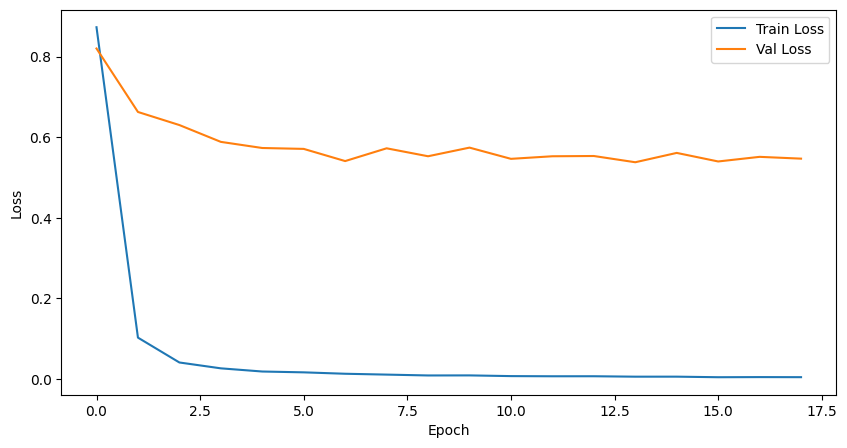


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


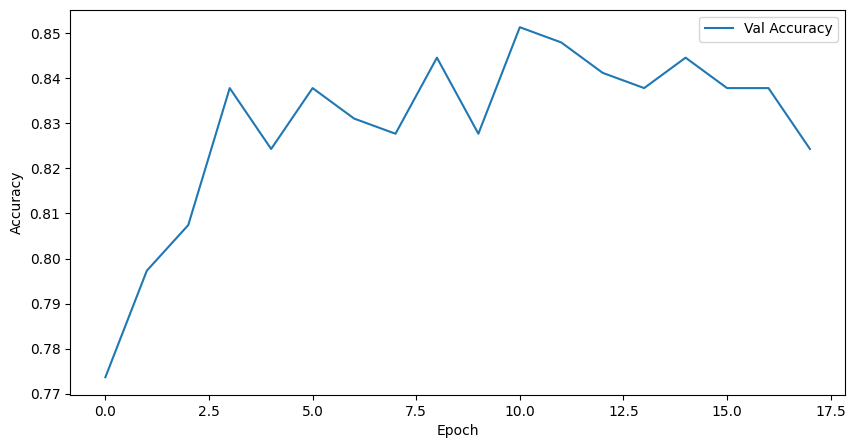

In [60]:
experiment_runner(3, 'ADAGRAD OPTIMIZER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**NAG optimizer**

In [61]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0001)

EXPERIMENT 3: NAG OPTIMIZER - using seed = 1


Epoch [1/30], Train Loss: 2.4669 Acc: 0.3917 | Val Loss: 2.0387 Acc: 0.4932
Epoch [2/30], Train Loss: 1.0882 Acc: 0.7644 | Val Loss: 1.4008 Acc: 0.6419
Epoch [3/30], Train Loss: 0.5602 Acc: 0.9182 | Val Loss: 1.1105 Acc: 0.6824
Epoch [4/30], Train Loss: 0.3251 Acc: 0.9663 | Val Loss: 0.9367 Acc: 0.7297
Epoch [5/30], Train Loss: 0.2062 Acc: 0.9864 | Val Loss: 0.8358 Acc: 0.7534
Epoch [6/30], Train Loss: 0.1435 Acc: 0.9917 | Val Loss: 0.7414 Acc: 0.7838
Epoch [7/30], Train Loss: 0.1032 Acc: 0.9962 | Val Loss: 0.6813 Acc: 0.8108
Epoch [8/30], Train Loss: 0.0782 Acc: 0.9966 | Val Loss: 0.6790 Acc: 0.8007
Epoch [9/30], Train Loss: 0.0618 Acc: 0.9992 | Val Loss: 0.6651 Acc: 0.8041
Epoch [10/30], Train Loss: 0.0534 Acc: 0.9996 | Val Loss: 0.6623 Acc: 0.7838
Epoch [11/30], Train Loss: 0.0424 Acc: 0.9992 | Val Loss: 0.6155 Acc: 0.8176
Epoch [12/30], Train Loss: 0.0368 Acc: 1.0000 | Val Loss: 0.6129 Acc: 0.8176
Epoch [13/30], Train Loss: 0.0354 Acc:

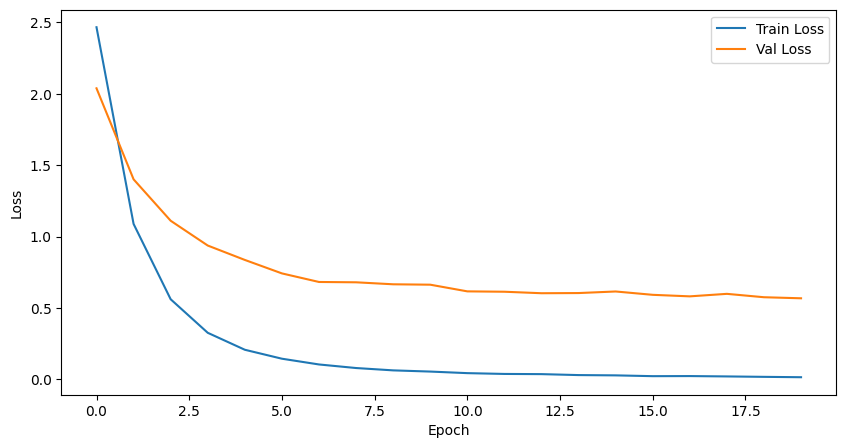


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


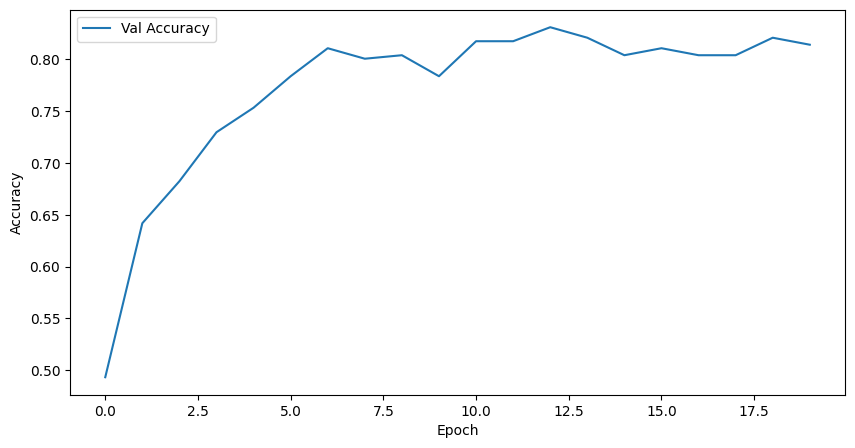

In [62]:
experiment_runner(3, 'NAG OPTIMIZER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**RAdam optimizer**

In [63]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.RAdam(model.parameters(), lr=0.0001, weight_decay=0.0001)

EXPERIMENT 3: RADAM OPTIMIZER - using seed = 1


Epoch [1/30], Train Loss: 3.3258 Acc: 0.1814 | Val Loss: 2.8563 Acc: 0.2872
Epoch [2/30], Train Loss: 1.8226 Acc: 0.6064 | Val Loss: 1.9595 Acc: 0.5203
Epoch [3/30], Train Loss: 0.9585 Acc: 0.8307 | Val Loss: 1.4587 Acc: 0.6419
Epoch [4/30], Train Loss: 0.4941 Acc: 0.9439 | Val Loss: 1.1388 Acc: 0.7095
Epoch [5/30], Train Loss: 0.2499 Acc: 0.9845 | Val Loss: 0.9614 Acc: 0.7500
Epoch [6/30], Train Loss: 0.1382 Acc: 0.9943 | Val Loss: 0.7993 Acc: 0.8007
Epoch [7/30], Train Loss: 0.0792 Acc: 0.9989 | Val Loss: 0.7221 Acc: 0.7973
Epoch [8/30], Train Loss: 0.0525 Acc: 0.9981 | Val Loss: 0.7142 Acc: 0.7939
Epoch [9/30], Train Loss: 0.0350 Acc: 0.9996 | Val Loss: 0.6671 Acc: 0.7939
Epoch [10/30], Train Loss: 0.0284 Acc: 1.0000 | Val Loss: 0.6615 Acc: 0.8108
Epoch [11/30], Train Loss: 0.0207 Acc: 1.0000 | Val Loss: 0.6444 Acc: 0.8041
Epoch [12/30], Train Loss: 0.0163 Acc: 1.0000 | Val Loss: 0.6188 Acc: 0.8108
Epoch [13/30], Train Loss: 0.0152 Ac

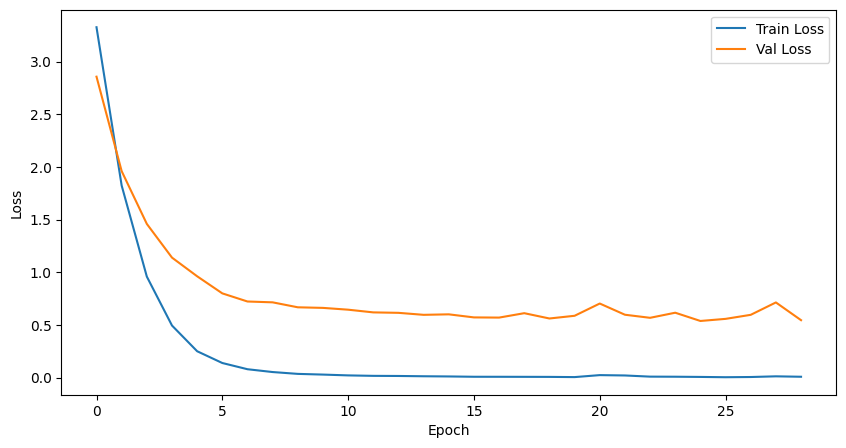


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


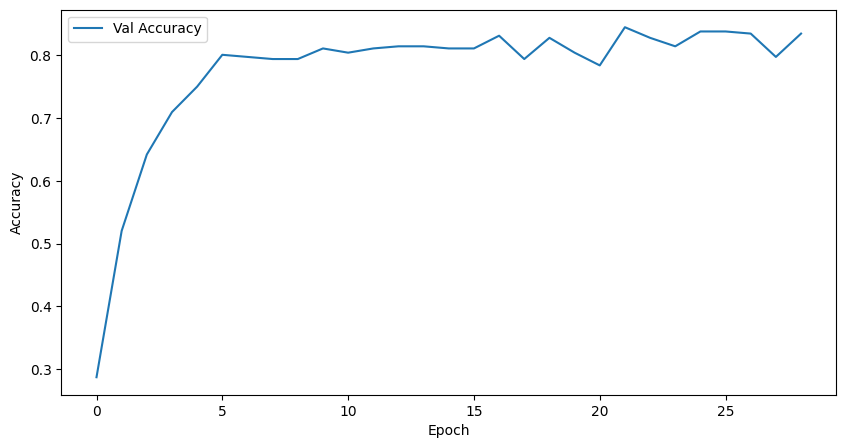

In [64]:
experiment_runner(3, 'RADAM OPTIMIZER', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, no choice of optimizer succeedes in improving validation accuracy.

### EXPERIMENT 4 - OPTIMIZATION OF WEIGHT DECAY HYPERPARAMETER

In this experiment, different choices for weight decay are compared; the original Adam Optimizer setup is exploited.

**Weight decay = 0.1**

In [65]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

EXPERIMENT 4: WEIGHT DECAY = 0.1 - using seed = 1


Epoch [1/30], Train Loss: 1.5208 Acc: 0.6511 | Val Loss: 1.1563 Acc: 0.6959
Epoch [2/30], Train Loss: 0.2523 Acc: 0.9727 | Val Loss: 0.8082 Acc: 0.7838
Epoch [3/30], Train Loss: 0.0701 Acc: 0.9977 | Val Loss: 0.6732 Acc: 0.8176
Epoch [4/30], Train Loss: 0.0337 Acc: 0.9985 | Val Loss: 0.6219 Acc: 0.8209
Epoch [5/30], Train Loss: 0.0192 Acc: 1.0000 | Val Loss: 0.6098 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0158 Acc: 1.0000 | Val Loss: 0.5383 Acc: 0.8378
Epoch [7/30], Train Loss: 0.0132 Acc: 0.9996 | Val Loss: 0.5466 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0187 Acc: 0.9973 | Val Loss: 0.5951 Acc: 0.8412
Epoch [9/30], Train Loss: 0.0084 Acc: 1.0000 | Val Loss: 0.5682 Acc: 0.8277
Epoch [10/30], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.5722 Acc: 0.8142
Epoch [11/30], Train Loss: 0.0050 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8446
Epoch [12/30], Train Loss: 0.0038 Acc: 1.0000 | Val Loss: 0.5378 Acc: 0.8311
Epoch [13/30], Train Loss: 0.0039

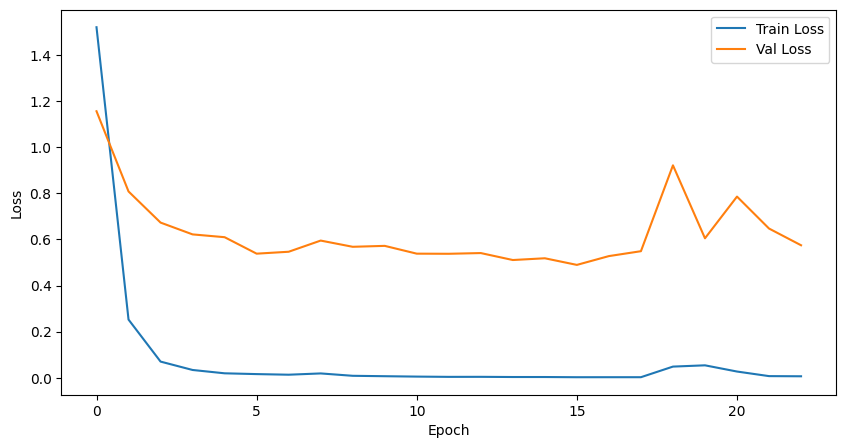


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


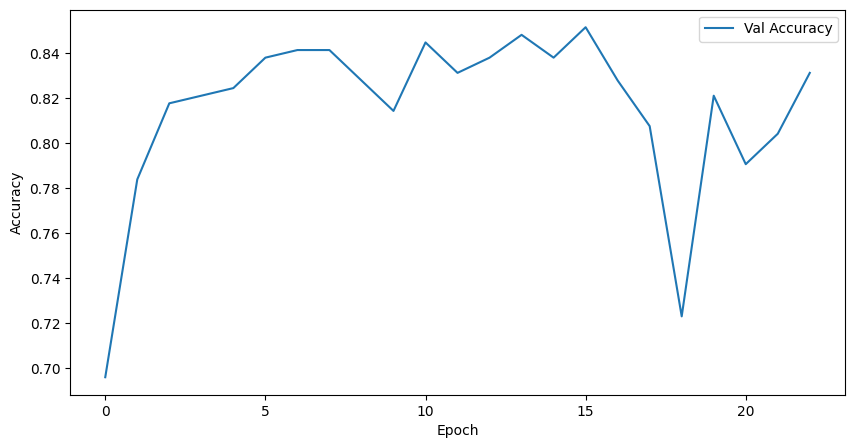

In [66]:
experiment_runner(4, 'WEIGHT DECAY = 0.1', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Weight decay = 0.01**

In [67]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

EXPERIMENT 4: WEIGHT DECAY = 0.01 - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6508 | Val Loss: 1.1540 Acc: 0.6959
Epoch [2/30], Train Loss: 0.2521 Acc: 0.9731 | Val Loss: 0.8042 Acc: 0.7804
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9977 | Val Loss: 0.6725 Acc: 0.8209
Epoch [4/30], Train Loss: 0.0336 Acc: 0.9985 | Val Loss: 0.6195 Acc: 0.8209
Epoch [5/30], Train Loss: 0.0189 Acc: 1.0000 | Val Loss: 0.6133 Acc: 0.8209
Epoch [6/30], Train Loss: 0.0149 Acc: 1.0000 | Val Loss: 0.5393 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0129 Acc: 0.9996 | Val Loss: 0.5482 Acc: 0.8345
Epoch [8/30], Train Loss: 0.0212 Acc: 0.9966 | Val Loss: 0.6258 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0090 Acc: 1.0000 | Val Loss: 0.5604 Acc: 0.8243
Epoch [10/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.5590 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0049 Acc: 1.0000 | Val Loss: 0.5354 Acc: 0.8547
Epoch [12/30], Train Loss: 0.0036 Acc: 1.0000 | Val Loss: 0.5361 Acc: 0.8345
Epoch [13/30], Train Loss: 0.003

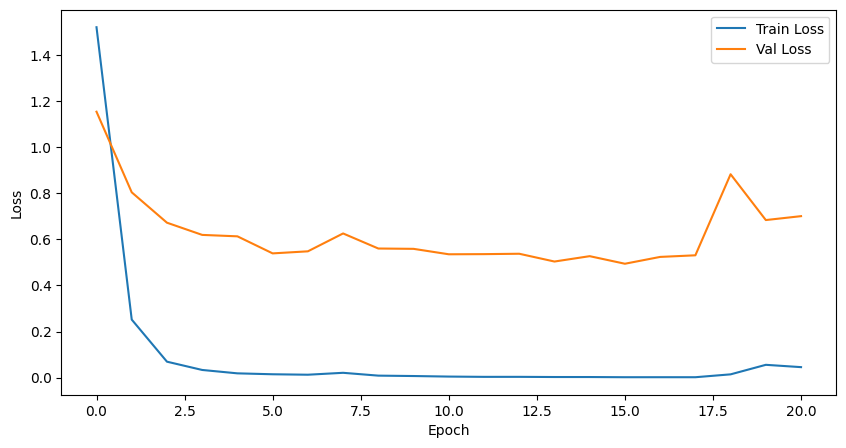


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


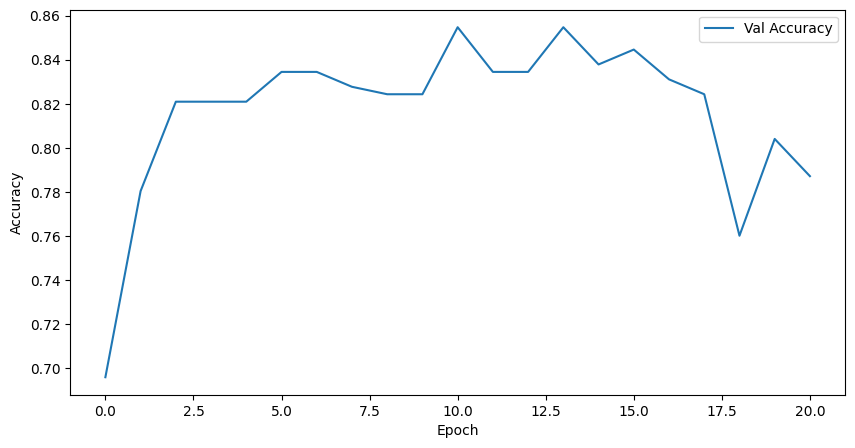

In [68]:
experiment_runner(4, 'WEIGHT DECAY = 0.01', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Weight decay = 0.001**

In [69]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)

EXPERIMENT 4: WEIGHT DECAY = 0.001 - using seed = 1


Epoch [1/30], Train Loss: 1.5203 Acc: 0.6523 | Val Loss: 1.1533 Acc: 0.6926
Epoch [2/30], Train Loss: 0.2518 Acc: 0.9731 | Val Loss: 0.8028 Acc: 0.7838
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6717 Acc: 0.8074
Epoch [4/30], Train Loss: 0.0330 Acc: 0.9985 | Val Loss: 0.6195 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0188 Acc: 1.0000 | Val Loss: 0.6089 Acc: 0.8277
Epoch [6/30], Train Loss: 0.0147 Acc: 1.0000 | Val Loss: 0.5370 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0126 Acc: 0.9996 | Val Loss: 0.5500 Acc: 0.8345
Epoch [8/30], Train Loss: 0.0207 Acc: 0.9970 | Val Loss: 0.6241 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0089 Acc: 1.0000 | Val Loss: 0.5532 Acc: 0.8345
Epoch [10/30], Train Loss: 0.0073 Acc: 1.0000 | Val Loss: 0.5606 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0049 Acc: 1.0000 | Val Loss: 0.5318 Acc: 0.8581
Epoch [12/30], Train Loss: 0.0036 Acc: 1.0000 | Val Loss: 0.5375 Acc: 0.8412
Epoch [13/30], Train Loss: 0.00

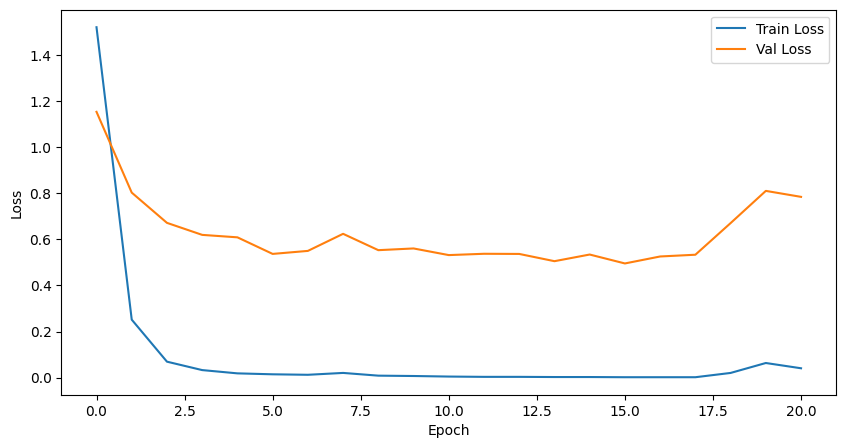


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


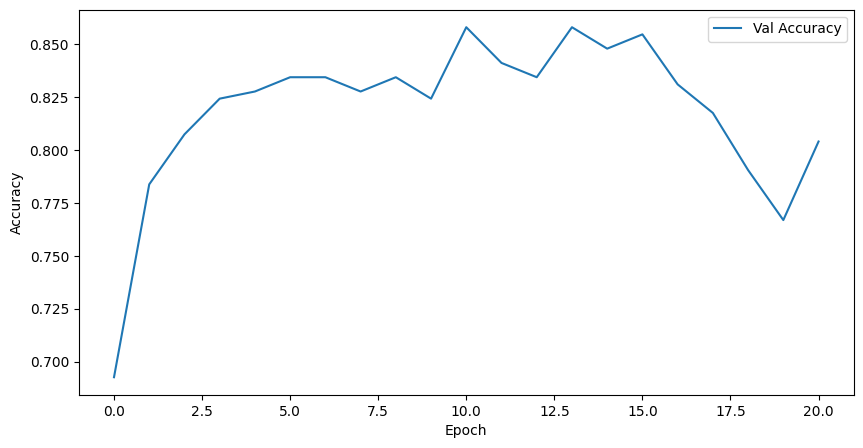

In [70]:
experiment_runner(4, 'WEIGHT DECAY = 0.001', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Weight decay = 0.0001**

In [71]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)

EXPERIMENT 4: WEIGHT DECAY = 0.00001 - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0196 Acc: 0.9973 | Val Loss: 0.6282 Acc: 0.8243
Epoch [9/30], Train Loss: 0.0084 Acc: 1.0000 | Val Loss: 0.5706 Acc: 0.8311
Epoch [10/30], Train Loss: 0.0064 Acc: 1.0000 | Val Loss: 0.5748 Acc: 0.8277
Epoch [11/30], Train Loss: 0.0047 Acc: 1.0000 | Val Loss: 0.5425 Acc: 0.8480
Epoch [12/30], Train Loss: 0.0036 Acc: 1.0000 | Val Loss: 0.5457 Acc: 0.8378
Epoch [13/30], Train Loss: 0.

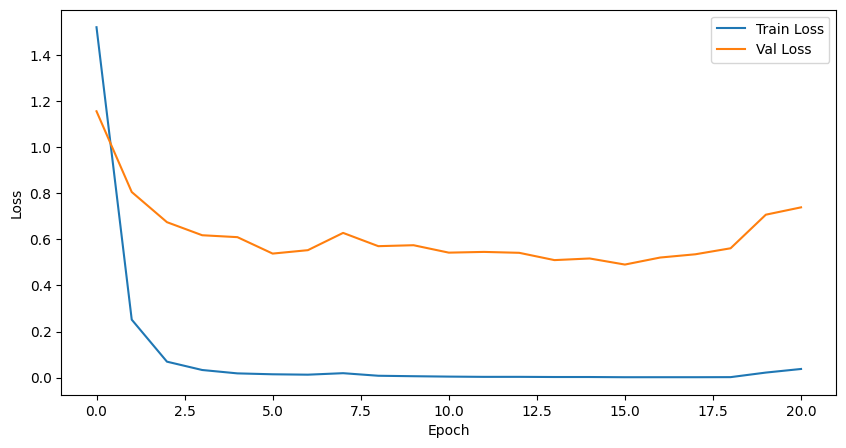


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


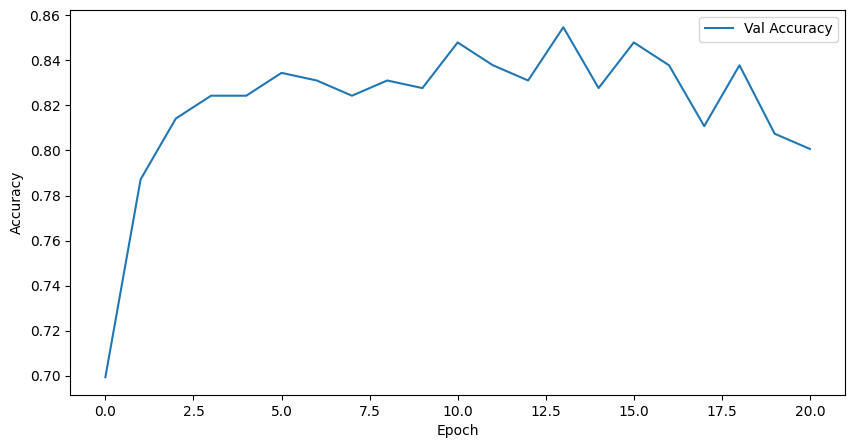

In [72]:
experiment_runner(4, 'WEIGHT DECAY = 0.00001', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, a change in weight decay hyperparameter has no substantial impact on validation accuracy.

### EXPERIMENT 5 - OPTIMIZATION OF BATCH SIZE

In this experiment, different choices for batch size are compared; the original setup is otherwise left as it is.

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Batch size = 8**

In [73]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

batch_size = 8

EXPERIMENT 5: BATCH SIZE = 8 - using seed = 1


Epoch [1/30], Train Loss: 1.3282 Acc: 0.6875 | Val Loss: 0.8705 Acc: 0.7500
Epoch [2/30], Train Loss: 0.2487 Acc: 0.9644 | Val Loss: 0.6560 Acc: 0.7939
Epoch [3/30], Train Loss: 0.1054 Acc: 0.9879 | Val Loss: 0.6539 Acc: 0.8378
Epoch [4/30], Train Loss: 0.0661 Acc: 0.9917 | Val Loss: 0.6591 Acc: 0.8074
Epoch [5/30], Train Loss: 0.0526 Acc: 0.9936 | Val Loss: 0.5755 Acc: 0.8311
Epoch [6/30], Train Loss: 0.0549 Acc: 0.9917 | Val Loss: 0.5684 Acc: 0.8209
Epoch [7/30], Train Loss: 0.0471 Acc: 0.9924 | Val Loss: 0.6175 Acc: 0.8345
Epoch [8/30], Train Loss: 0.0350 Acc: 0.9939 | Val Loss: 0.5255 Acc: 0.8480
Epoch [9/30], Train Loss: 0.0133 Acc: 1.0000 | Val Loss: 0.5567 Acc: 0.8446
Epoch [10/30], Train Loss: 0.0158 Acc: 0.9985 | Val Loss: 0.5486 Acc: 0.8446
Epoch [11/30], Train Loss: 0.0168 Acc: 0.9989 | Val Loss: 0.5982 Acc: 0.8277
Epoch [12/30], Train Loss: 0.0097 Acc: 0.9996 | Val Loss: 0.5710 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0139 Acc

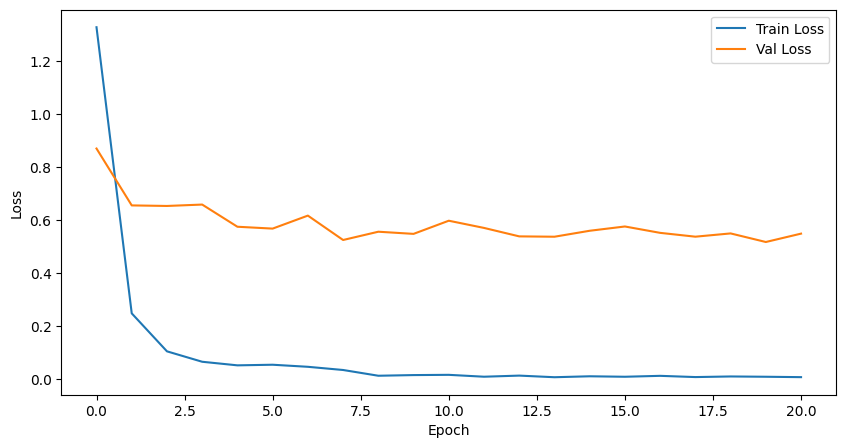


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


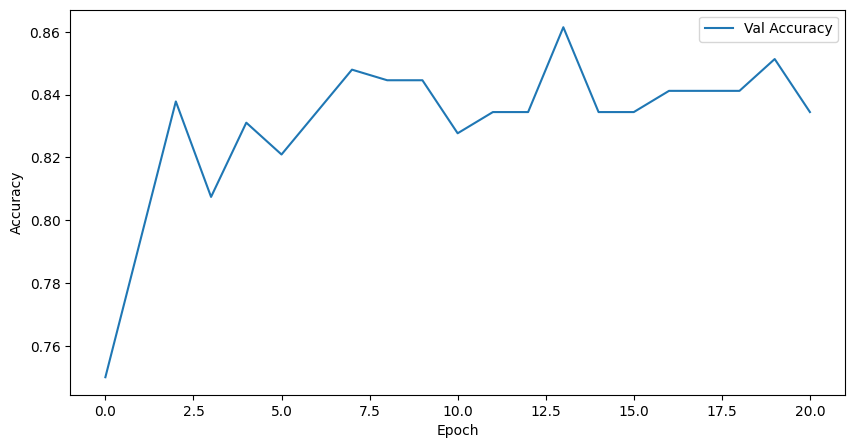

In [74]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

experiment_runner(5, 'BATCH SIZE = 8', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Batch size = 16**

In [75]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

batch_size = 16

EXPERIMENT 5: BATCH SIZE = 16 - using seed = 1


Epoch [1/30], Train Loss: 1.3408 Acc: 0.6970 | Val Loss: 0.9434 Acc: 0.7230
Epoch [2/30], Train Loss: 0.2082 Acc: 0.9765 | Val Loss: 0.6679 Acc: 0.7973
Epoch [3/30], Train Loss: 0.0663 Acc: 0.9966 | Val Loss: 0.6405 Acc: 0.8108
Epoch [4/30], Train Loss: 0.0328 Acc: 0.9989 | Val Loss: 0.6830 Acc: 0.8345
Epoch [5/30], Train Loss: 0.0186 Acc: 0.9996 | Val Loss: 0.5360 Acc: 0.8378
Epoch [6/30], Train Loss: 0.0210 Acc: 0.9977 | Val Loss: 0.5584 Acc: 0.8547
Epoch [7/30], Train Loss: 0.0274 Acc: 0.9977 | Val Loss: 0.5284 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0170 Acc: 0.9989 | Val Loss: 0.5129 Acc: 0.8547
Epoch [9/30], Train Loss: 0.0102 Acc: 0.9996 | Val Loss: 0.4897 Acc: 0.8784
Epoch [10/30], Train Loss: 0.0109 Acc: 0.9985 | Val Loss: 0.5296 Acc: 0.8480
Epoch [11/30], Train Loss: 0.0097 Acc: 1.0000 | Val Loss: 0.5000 Acc: 0.8750
Epoch [12/30], Train Loss: 0.0075 Acc: 1.0000 | Val Loss: 0.4922 Acc: 0.8514
Epoch [13/30], Train Loss: 0.0077 Ac

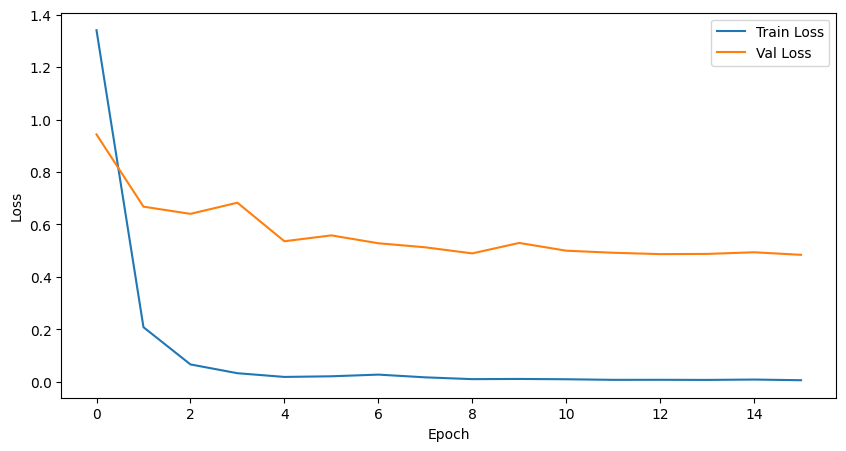


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


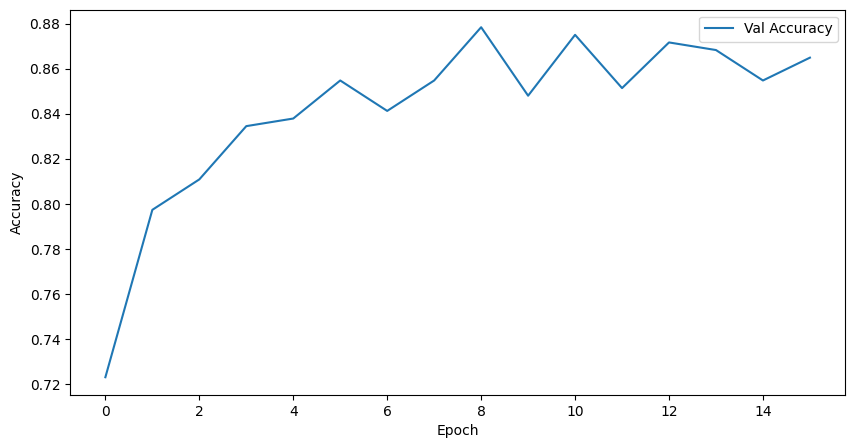

In [76]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

experiment_runner(5, 'BATCH SIZE = 16', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Batch size = 64**

In [78]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

batch_size = 64

EXPERIMENT 5: BATCH SIZE = 64 - using seed = 1


Epoch [1/30], Train Loss: 1.8381 Acc: 0.5674 | Val Loss: 1.4379 Acc: 0.6216
Epoch [2/30], Train Loss: 0.4028 Acc: 0.9420 | Val Loss: 1.0033 Acc: 0.7365
Epoch [3/30], Train Loss: 0.1175 Acc: 0.9962 | Val Loss: 0.8050 Acc: 0.7939
Epoch [4/30], Train Loss: 0.0453 Acc: 1.0000 | Val Loss: 0.7181 Acc: 0.7973
Epoch [5/30], Train Loss: 0.0271 Acc: 1.0000 | Val Loss: 0.7059 Acc: 0.8108
Epoch [6/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6323 Acc: 0.8243
Epoch [7/30], Train Loss: 0.0130 Acc: 1.0000 | Val Loss: 0.6302 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0106 Acc: 1.0000 | Val Loss: 0.6534 Acc: 0.8209
Epoch [9/30], Train Loss: 0.0102 Acc: 1.0000 | Val Loss: 0.6161 Acc: 0.8345
Epoch [10/30], Train Loss: 0.0099 Acc: 1.0000 | Val Loss: 0.6218 Acc: 0.8345
Epoch [11/30], Train Loss: 0.0100 Acc: 1.0000 | Val Loss: 0.6237 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0099 Acc: 1.0000 | Val Loss: 0.6135 Acc: 0.8243
Epoch [13/30], Train Loss: 0.0099 Ac

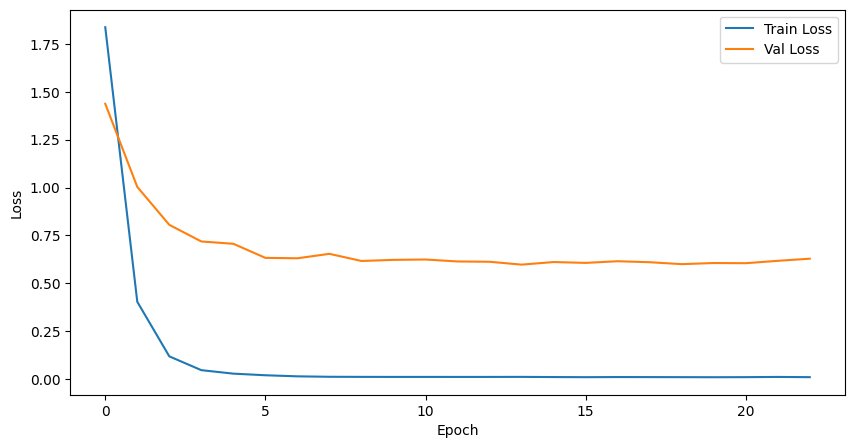


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


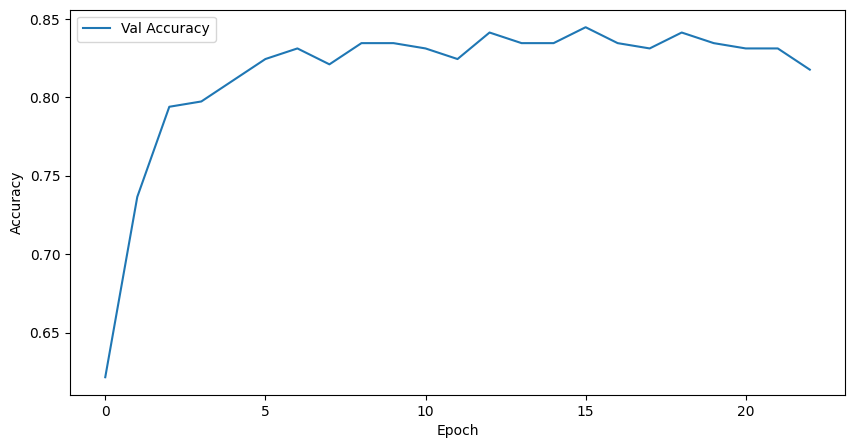

In [79]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

experiment_runner(5, 'BATCH SIZE = 64', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, a choice of batch size = 16 successfully improves validation accuracy.

### EXPERIMENT 6 - OPTIMIZATION OF PATIENCE HYPERPARAMETER

In this experiment, different choices for patience are compared; the original setup is otherwise left as it is.

**Patience = 3**

In [80]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

patience = 3

EXPERIMENT 6: PATIENCE = 3 - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/30], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Early stopping triggered
Maximum val ac

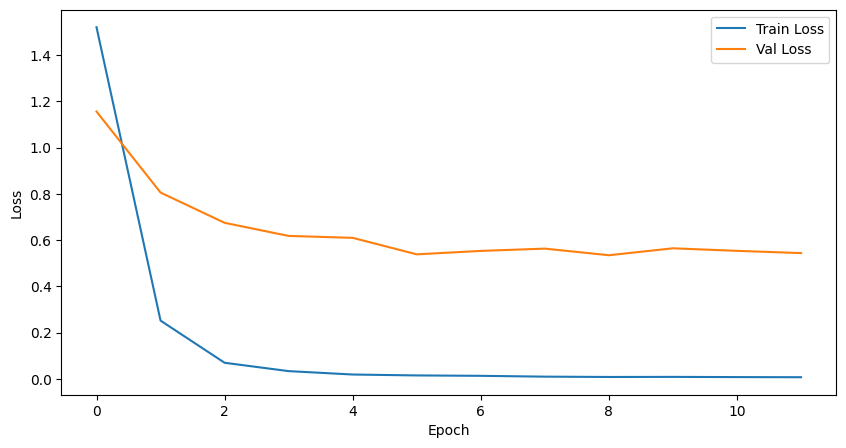


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


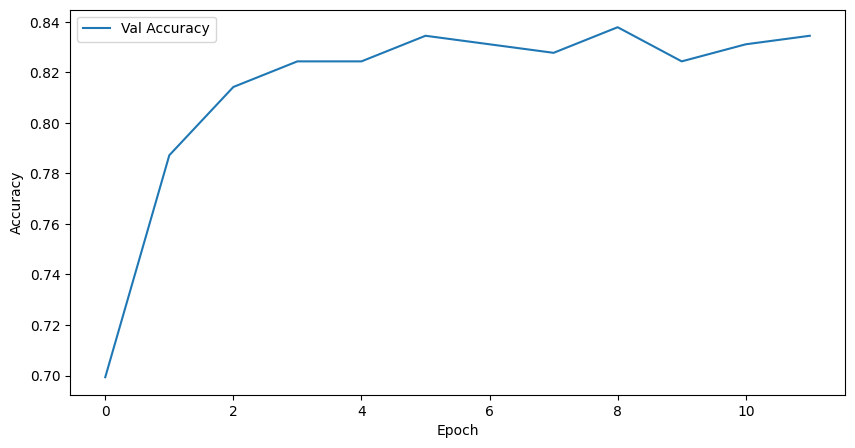

In [81]:
experiment_runner(6, 'PATIENCE = 3', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Patience = 5**

In [82]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

patience = 5

EXPERIMENT 6: PATIENCE = 5 - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/30], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0077 Acc: 

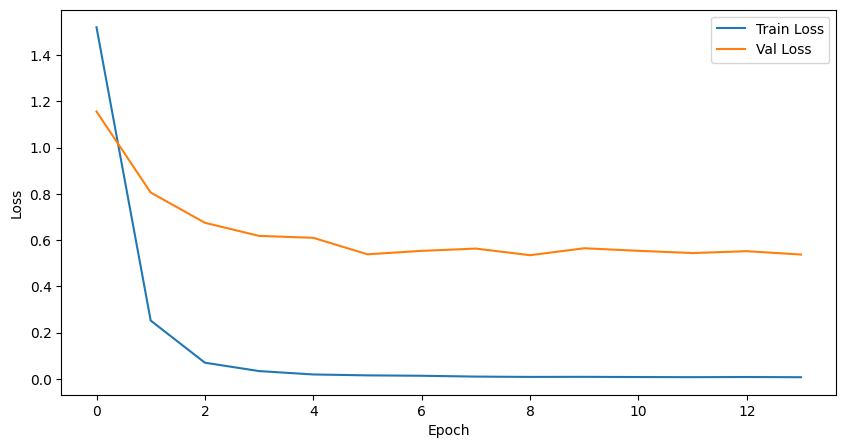


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


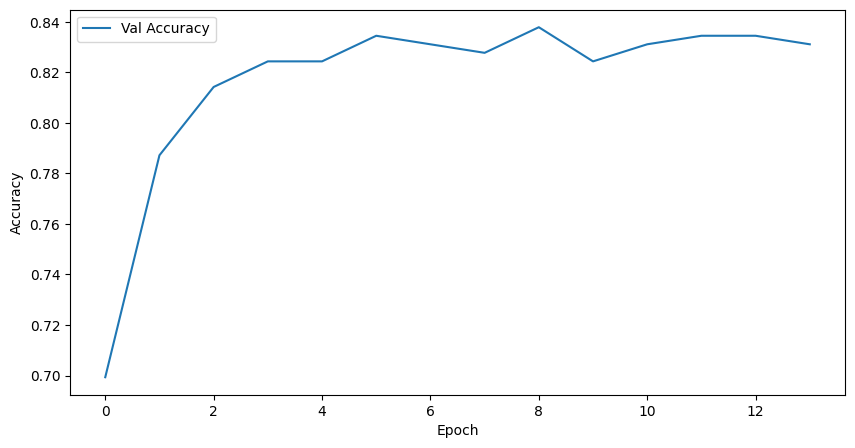

In [83]:
experiment_runner(6, 'PATIENCE = 5', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Patience = 10**

In [84]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

patience = 10

EXPERIMENT 6: PATIENCE = 10 - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/30], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0077 Acc:

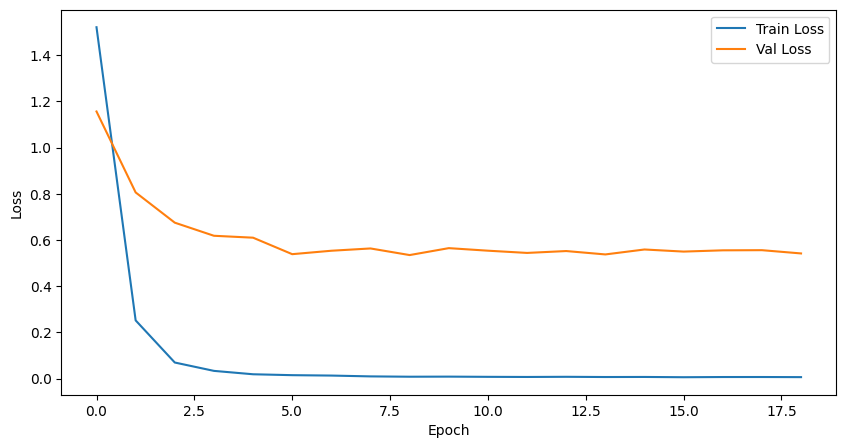


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


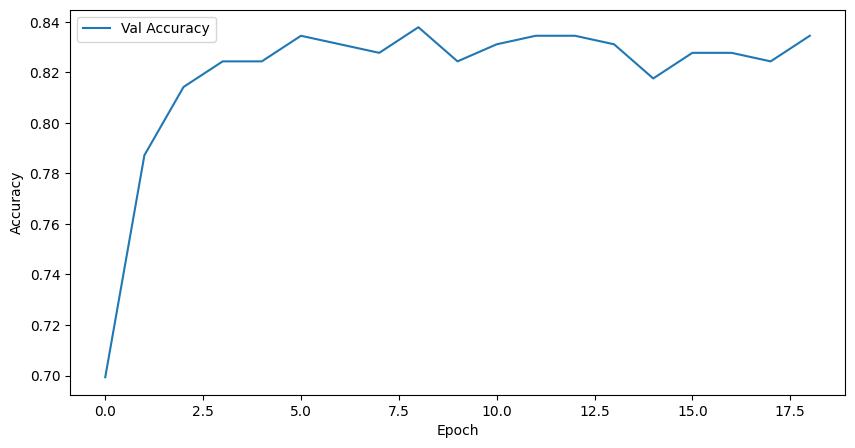

In [85]:
experiment_runner(6, 'PATIENCE = 10', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Patience = 30**

In [86]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

patience = 30

EXPERIMENT 6: PATIENCE = 30 - using seed = 1


Epoch [1/30], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/30], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/30], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/30], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/30], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0077 Acc:

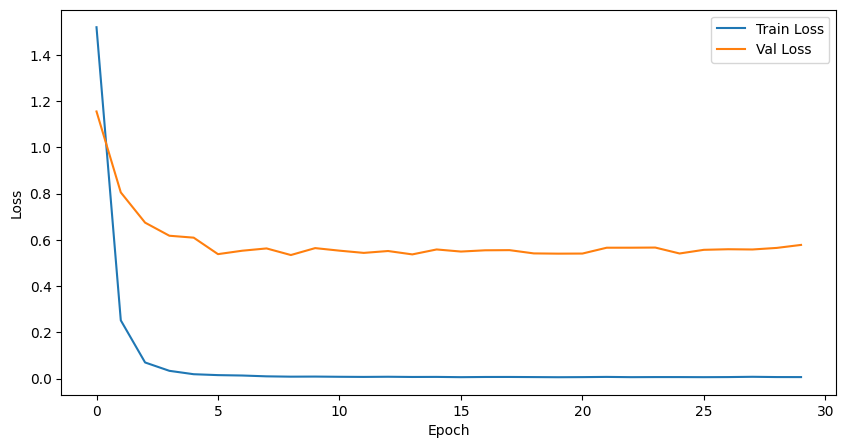


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


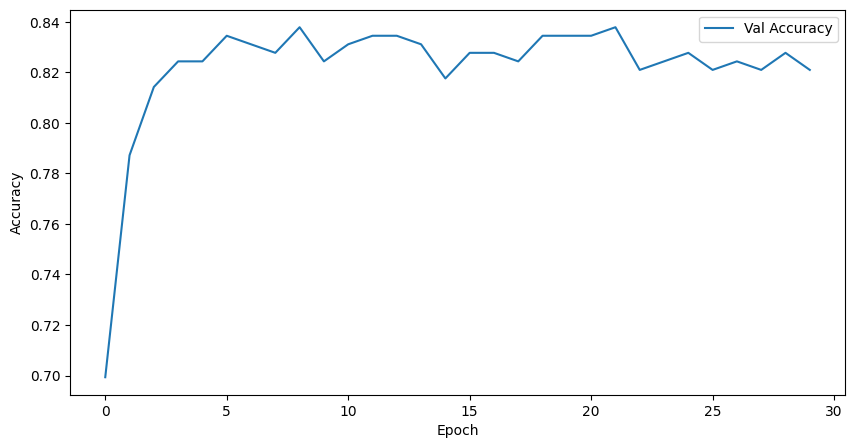

In [87]:
experiment_runner(6, 'PATIENCE = 30', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, a change in patience hyperparameter has no substantial impact on validation accuracy.

### EXPERIMENT 7 - OPTIMIZATION OF NUMBER OF EPOCHS

This experiment explores the impact of varying the number of training epochs on the validation accuracy. In order to correctly evaluate each experiment, the patience value is set as equal to the number of epochs.

**Number of epochs = 40**

In [88]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

num_epochs = 40
patience = 40

EXPERIMENT 7: NUMBER OF EPOCHS = 40 - using seed = 1


Epoch [1/40], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/40], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/40], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/40], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/40], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/40], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/40], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/40], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/40], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/40], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/40], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/40], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Epoch [13/40], Train Loss: 0.0

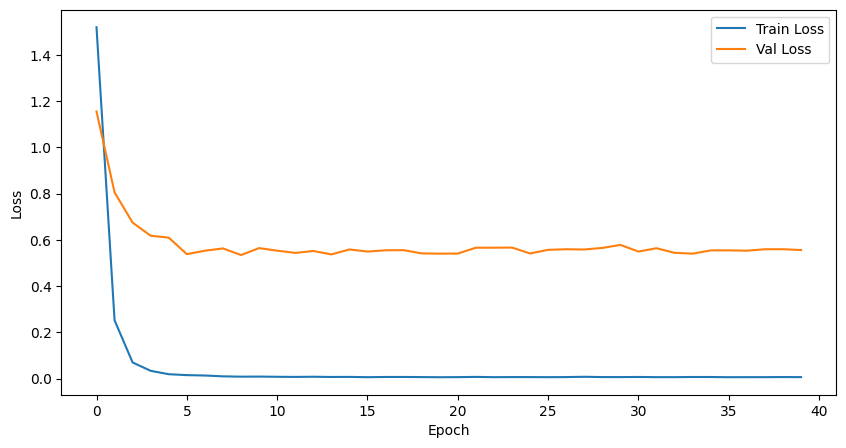


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


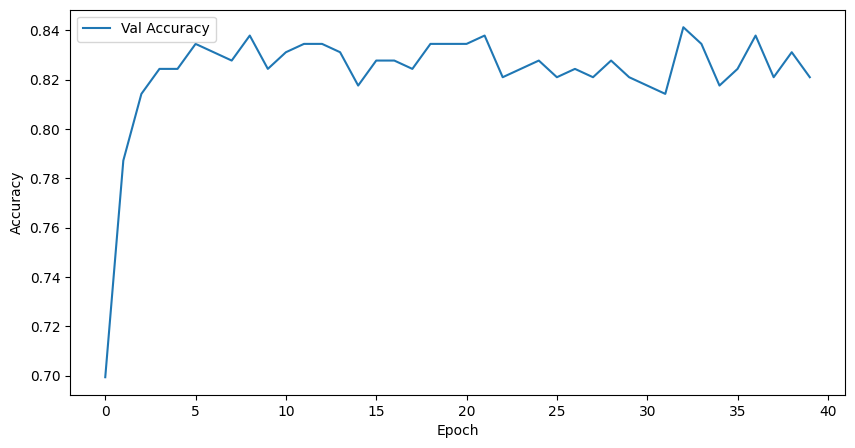

In [89]:
experiment_runner(7, 'NUMBER OF EPOCHS = 40', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Number of epochs = 50**

In [90]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

num_epochs = 50
patience = 50

EXPERIMENT 7: NUMBER OF EPOCHS = 50 - using seed = 1


Epoch [1/50], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/50], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/50], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/50], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/50], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/50], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/50], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/50], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/50], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/50], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/50], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/50], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Epoch [13/50], Train Loss: 0.0

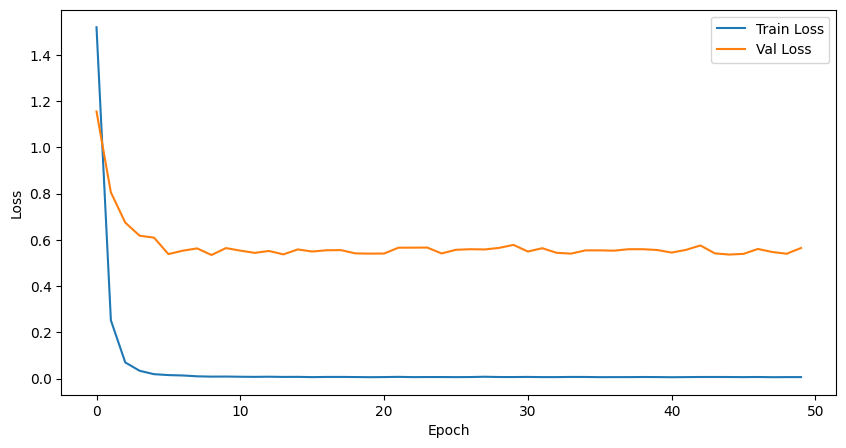


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


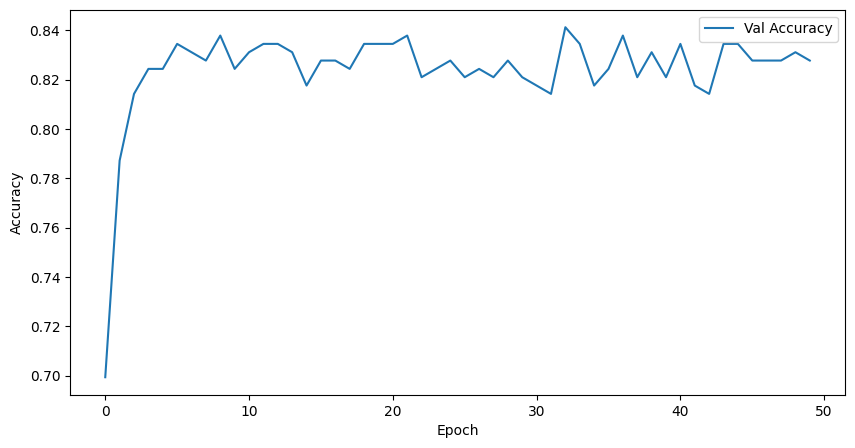

In [91]:
experiment_runner(7, 'NUMBER OF EPOCHS = 50', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

**Number of epochs = 100**

In [92]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(1, train_dataset, test_dataset, val_dataset, device)

num_epochs = 100
patience = 100

EXPERIMENT 7: NUMBER OF EPOCHS = 100 - using seed = 1


Epoch [1/100], Train Loss: 1.5205 Acc: 0.6511 | Val Loss: 1.1559 Acc: 0.6993
Epoch [2/100], Train Loss: 0.2519 Acc: 0.9727 | Val Loss: 0.8056 Acc: 0.7872
Epoch [3/100], Train Loss: 0.0695 Acc: 0.9985 | Val Loss: 0.6747 Acc: 0.8142
Epoch [4/100], Train Loss: 0.0334 Acc: 0.9985 | Val Loss: 0.6180 Acc: 0.8243
Epoch [5/100], Train Loss: 0.0187 Acc: 1.0000 | Val Loss: 0.6097 Acc: 0.8243
Epoch [6/100], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5384 Acc: 0.8345
Epoch [7/100], Train Loss: 0.0131 Acc: 0.9992 | Val Loss: 0.5533 Acc: 0.8311
Epoch [8/100], Train Loss: 0.0095 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8277
Epoch [9/100], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5345 Acc: 0.8378
Epoch [10/100], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5645 Acc: 0.8243
Epoch [11/100], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5535 Acc: 0.8311
Epoch [12/100], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5438 Acc: 0.8345
Epoch [13/100], T

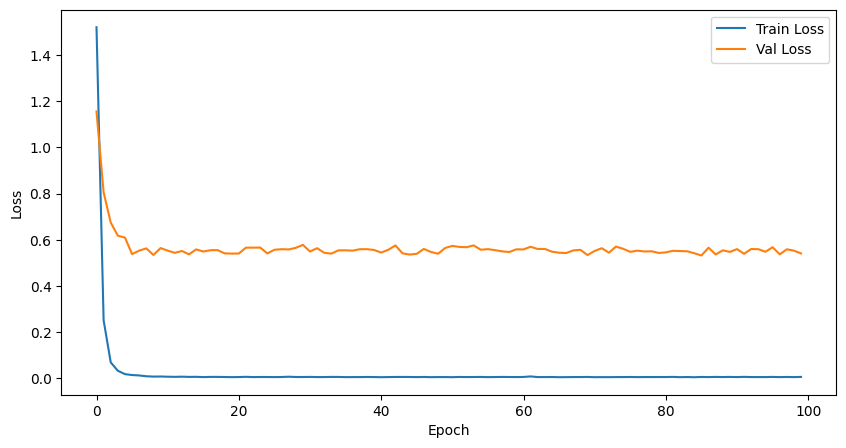


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


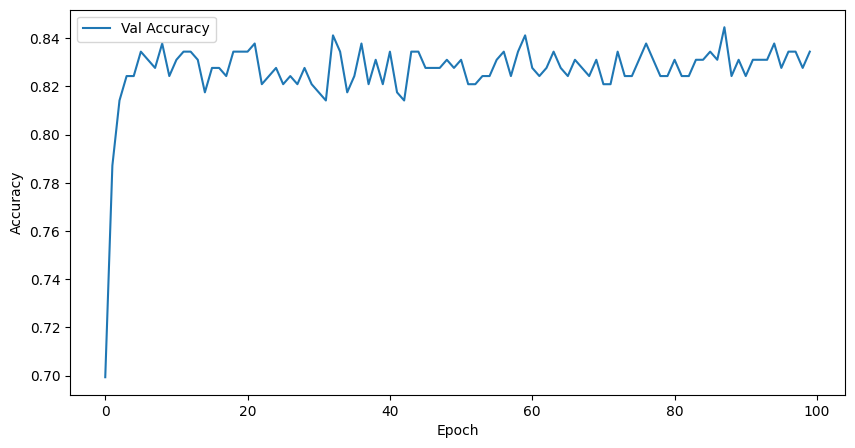

In [93]:
experiment_runner(7, 'NUMBER OF EPOCHS = 100', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

As observed, a change in the number of epochs has no substantial impact on validation accuracy.

### FINAL OBSERVATIONS
The initial model achieved good accuracy on the validation set, and subsequent hyperparameter tuning experiments, while not drastically improving performance, did not significantly degrade it either. The results remained within the desired range, with the most notable improvement achieved through batch size optimization.